In [1]:
import numpy as np
from swmm_api import read_rpt_file,read_inp_file,read_out_file
from os import listdir
from os.path import exists
from matplotlib import pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.dates as mdates

from env_swmm_real import Ast
from Cen_RL import Cen_RL
from vdn import VDN
from iql import IQL

from datetime import datetime,timedelta
import pandas as pd

plt.rc('font',family = 'Times New Roman')


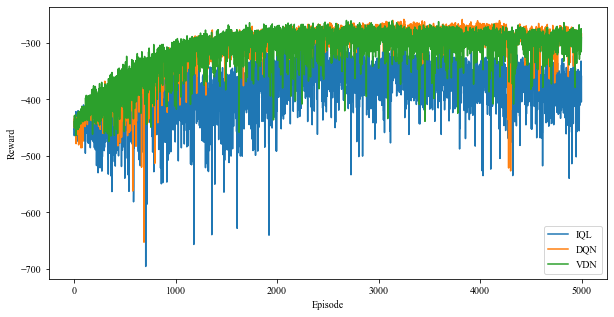

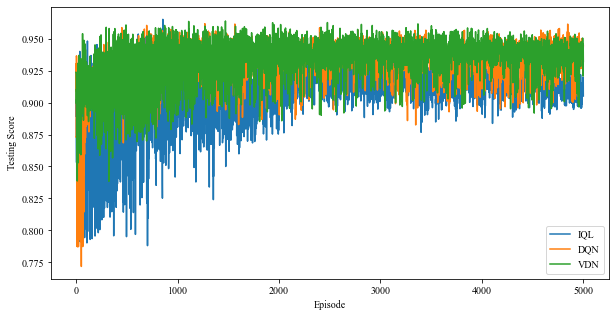

In [3]:
train_path = './model/%s/episode_reward_history.npy'
test_path = './model/%s/test_reward_history.npy'
fig,ax = plt.subplots(nrows=1,ncols=1,figsize = (10,5))
fig2,axR = plt.subplots(nrows=1,ncols=1,figsize = (10,5))
lines,lines2 = [],[]
for i,f in enumerate(['IQL','DQN','VDN']):
    episode_reward_history = np.load(train_path%f).tolist()
    test_reward_history = np.load(test_path%f).tolist()
    train = ax.plot(np.arange(len(episode_reward_history)),episode_reward_history,label=f)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    lines+=train
    
    test = axR.plot(np.arange(len(test_reward_history)),test_reward_history,label=f)
    axR.set_xlabel('Episode')
    axR.set_ylabel('Testing Score')
    lines2+=test
    
ax.legend(lines,[f.get_label() for f in lines],loc='lower right')
axR.legend(lines2,[f.get_label() for f in lines2],loc='lower right')
fig.savefig('./train/train.png',dpi=600)
fig2.savefig('./train/test.png',dpi=600)

In [7]:

fail_dir = './test/observe_fail/'
inps = [inp for inp in listdir(fail_dir) if inp.endswith('.inp') and 'DQN' in inp]
times = [(read_inp_file(fail_dir+inp).OPTIONS.START_DATE,
          read_inp_file(fail_dir+inp).OPTIONS.START_TIME,
          read_inp_file(fail_dir+inp).OPTIONS.END_DATE,
          read_inp_file(fail_dir+inp).OPTIONS.END_TIME) for inp in inps]
times = [(tu[0].strftime('%m/%d/%Y')+' '+tu[1].strftime('%H:%M:%S'),
          tu[2].strftime('%m/%d/%Y')+' '+tu[3].strftime('%H:%M:%S')) for tu in times]


In [8]:
fail_dir = './test/observe_fail/'
cen_datas = np.load(fail_dir+'cen_fail_data.npy')
vdn_datas = np.load(fail_dir+'vdn_fail_data.npy')
refers = np.load(fail_dir+'fail_refer.npy')
columns = ['BC','IQL','DQN','VDN']

fig = plt.figure(figsize=(15,15),dpi = 600)
for i,data in enumerate(cen_datas):
    refer = refers[i]
    ax = fig.add_subplot(2,2,i+1)
    # fig = plt.figure(figsize=(10,10),dpi = 600)
    # ax = fig.add_subplot(1,1,1)
    labels = [str(i*0.1)[:3] for i in range(1,11)]
    data = data.T
    cen_stats = cbook.boxplot_stats(data, bootstrap=10000)
    vdn_stats = cbook.boxplot_stats(vdn_datas[i].T,bootstrap=10000)


    cen = ax.bxp(cen_stats,patch_artist=True,showfliers=False,positions=tuple([i-0.15 for i in range(1,11)]),widths=0.3)
    for patch in cen['boxes']:
        patch.set_facecolor('lightgreen')
    for med in cen['medians']:
        med.set_color('black')
    vdn = ax.bxp(vdn_stats,patch_artist=True,showfliers=False,positions=tuple([i+0.15 for i in range(1,11)]),widths=0.3)
    for patch in vdn['boxes']:
        patch.set_facecolor('salmon')   
    for med in vdn['medians']:
        med.set_color('black')
    lines = []
    colors = ['blue','orange','green','red']
    for j,ref in enumerate(refer):
        line = ax.axhline(y=ref,linestyle='--',label=columns[j],color=colors[j])
        lines.append(line)
    ax.set_title(times[i][0][:10],fontsize=14)
    ax.legend(lines+[cen['boxes'][0],vdn['boxes'][0]],[l.get_label() for l in lines]+['DQN_fail','VDN_fail'],loc='upper left')
    plt.xticks([1,2,3,4,5,6,7,8,9,10],labels)
    ax.set_xlabel('Failure probability',fontsize=14)
    ax.set_ylabel('Accumulated CSO volume ($\mathregular{10^3} \mathregular{m^3}$)',fontsize=14)
    # fig.savefig(fail_dir+'fail%s.png'%times[i][0][:10].replace('/','_'),dpi=600)
fig.savefig(fail_dir+'fail.png',dpi=600)


In [9]:
fail_dir = './test/act_fail/'

cen_datas = np.load(fail_dir+'cen_fail_data.npy')
datas = np.load(fail_dir+'fail_data.npy')
refers = np.load(fail_dir+'fail_refer.npy')
columns = ['BC','IQL','DQN','VDN']
fig = plt.figure(figsize=(15,15),dpi = 600)
for i,data in enumerate(cen_datas):
    # fig = plt.figure(figsize=(10,8),dpi = 600)
    # ax = fig.add_subplot(1,1,1)
    ax = fig.add_subplot(2,2,i+1)
    refer = refers[i]
    labels = [str(j*0.1)[:3] for j in range(1,11)]
    data = data.T
    cen_stats = cbook.boxplot_stats(data, bootstrap=10000)
    stats = cbook.boxplot_stats(datas[i].T, bootstrap=10000)
    
    cen = ax.bxp(cen_stats,patch_artist=True,showfliers=False,positions=tuple([i-0.15 for i in range(1,11)]),widths=0.3)    
    for patch in cen['boxes']:
        patch.set_facecolor('lightgreen')
    for med in cen['medians']:
        med.set_color('black')
    dat = ax.bxp(stats,patch_artist=True,showfliers=False,positions=tuple([i+0.15 for i in range(1,11)]),widths=0.3)
    for patch in dat['boxes']:
        patch.set_facecolor('salmon')   
    for med in dat['medians']:
        med.set_color('black')
    lines = []
    colors = ['blue','orange','red','green']
    for j,ref in enumerate(refer):
        line = ax.axhline(y=ref,linestyle='--',label=columns[j],color=colors[j])
        lines.append(line)
    ax.set_title(times[i][0][:10])
    ax.legend(lines+[cen['boxes'][0],dat['boxes'][0]],[l.get_label() for l in lines]+['DQN_fail','DQN&VDN'],loc='upper left')
    plt.xticks([1,2,3,4,5,6,7,8,9,10],labels)
    ax.set_xlabel('Failure probability',fontsize=14)
    ax.set_ylabel('Accumulated CSO volume ($\mathregular{10^3} \mathregular{m^3}$)',fontsize=14)
    # fig.savefig(fail_dir+'fail%s.png'%times[i][0][:10].replace('/','_'),dpi=600)
fig.savefig(fail_dir+'fail.png',dpi=600)


In [10]:
env = Ast(inp_test_file='./test/Real_{0}_{1}.inp')

In [11]:
columns = ['IQL','DQN','VDN']
time = ('10/01/2009 14:25:00','')
#time = ('02/13/2009 15:45:00','')
dt_time = datetime.strptime(time[0],'%m/%d/%Y %H:%M:%S')
files = []
for f in ['IQL','DQN','VDN']:
    env.filedir = env.inp_test_file.format(f,str(dt_time.date())+'-'+str(dt_time.hour))
    files.append(env.filedir)


In [12]:
cen_rl = Cen_RL(action_size = env.action_size)
cen_rl.load(model_dir='./model/DQN/')
vdnn = VDN(action_size = env.action_size,RGs = [2,0,2,1])
vdnn.load(model_dir='./model/VDN/')
iqll = IQL(action_size = env.action_size,RGs = [2,0,2,1])
iqll.load(model_dir='./model/IQL/')


In [15]:
for f in [iqll,cen_rl,vdnn]:
    env.filedir = env.inp_test_file.format(f.name,str(dt_time.date())+'-'+str(dt_time.hour))
    if exists(env.filedir.replace('inp','out')) and exists(env.filedir.replace('inp','rpt')):
        continue
    _,_,_ = env.test(f,time,filedir=env.filedir)

In [16]:
env.filedir

'./test/Real_VDN_2009-10-01-14.inp'

In [17]:
inp = read_inp_file(files[-1])
rains = pd.DataFrame()
for k,v in inp.TIMESERIES.items():
    rain = v.frame
    rains[k] = rain

In [18]:
rains

rain1  rain2  rain3  rain4
2009-10-01 14:30:00    0.0   0.66   0.00   0.00
2009-10-01 14:35:00    0.0   0.76   0.00   0.12
2009-10-01 14:40:00    0.0   0.76   0.00   0.30
2009-10-01 14:45:00    0.0   0.46   0.00   1.20
2009-10-01 14:50:00    0.0   0.48   0.01   0.70
...                    ...    ...    ...    ...
2009-10-01 22:00:00    0.0   0.00   0.00   0.00
2009-10-01 22:05:00    0.0   0.00   0.00   0.00
2009-10-01 22:10:00    0.0   0.00   0.00   0.00
2009-10-01 22:15:00    0.0   0.00   0.00   0.00
2009-10-01 22:20:00    0.0   0.00   0.00   0.00

[95 rows x 4 columns]

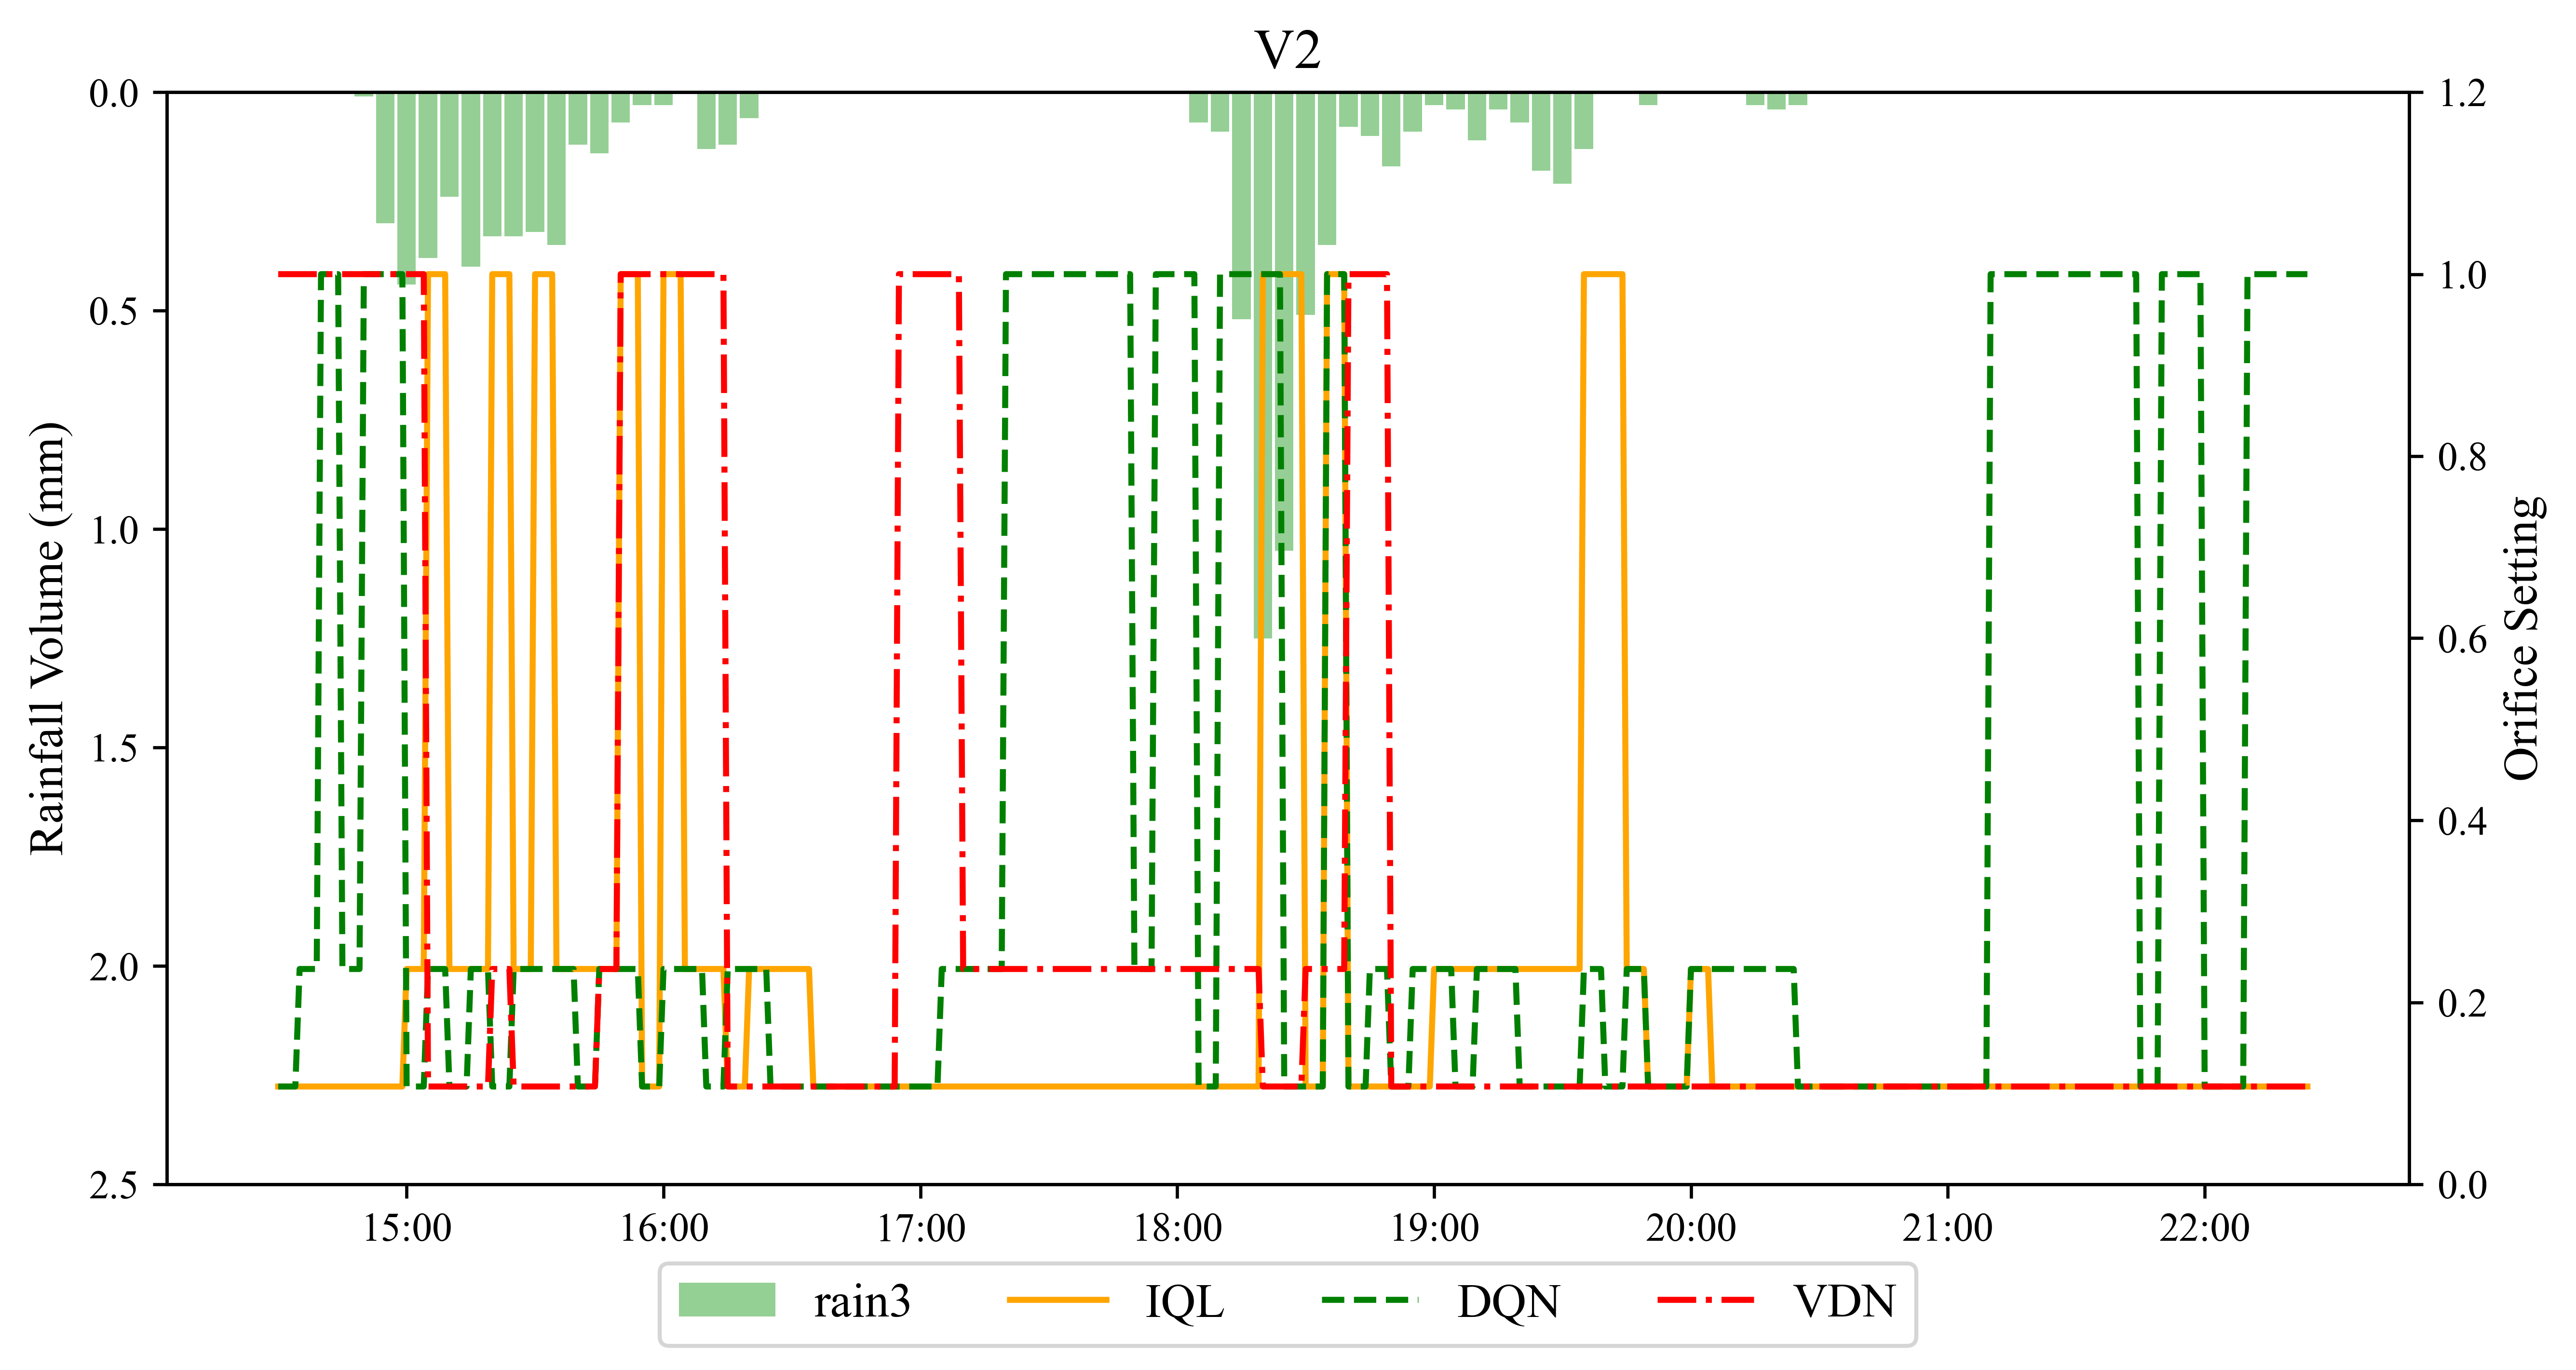

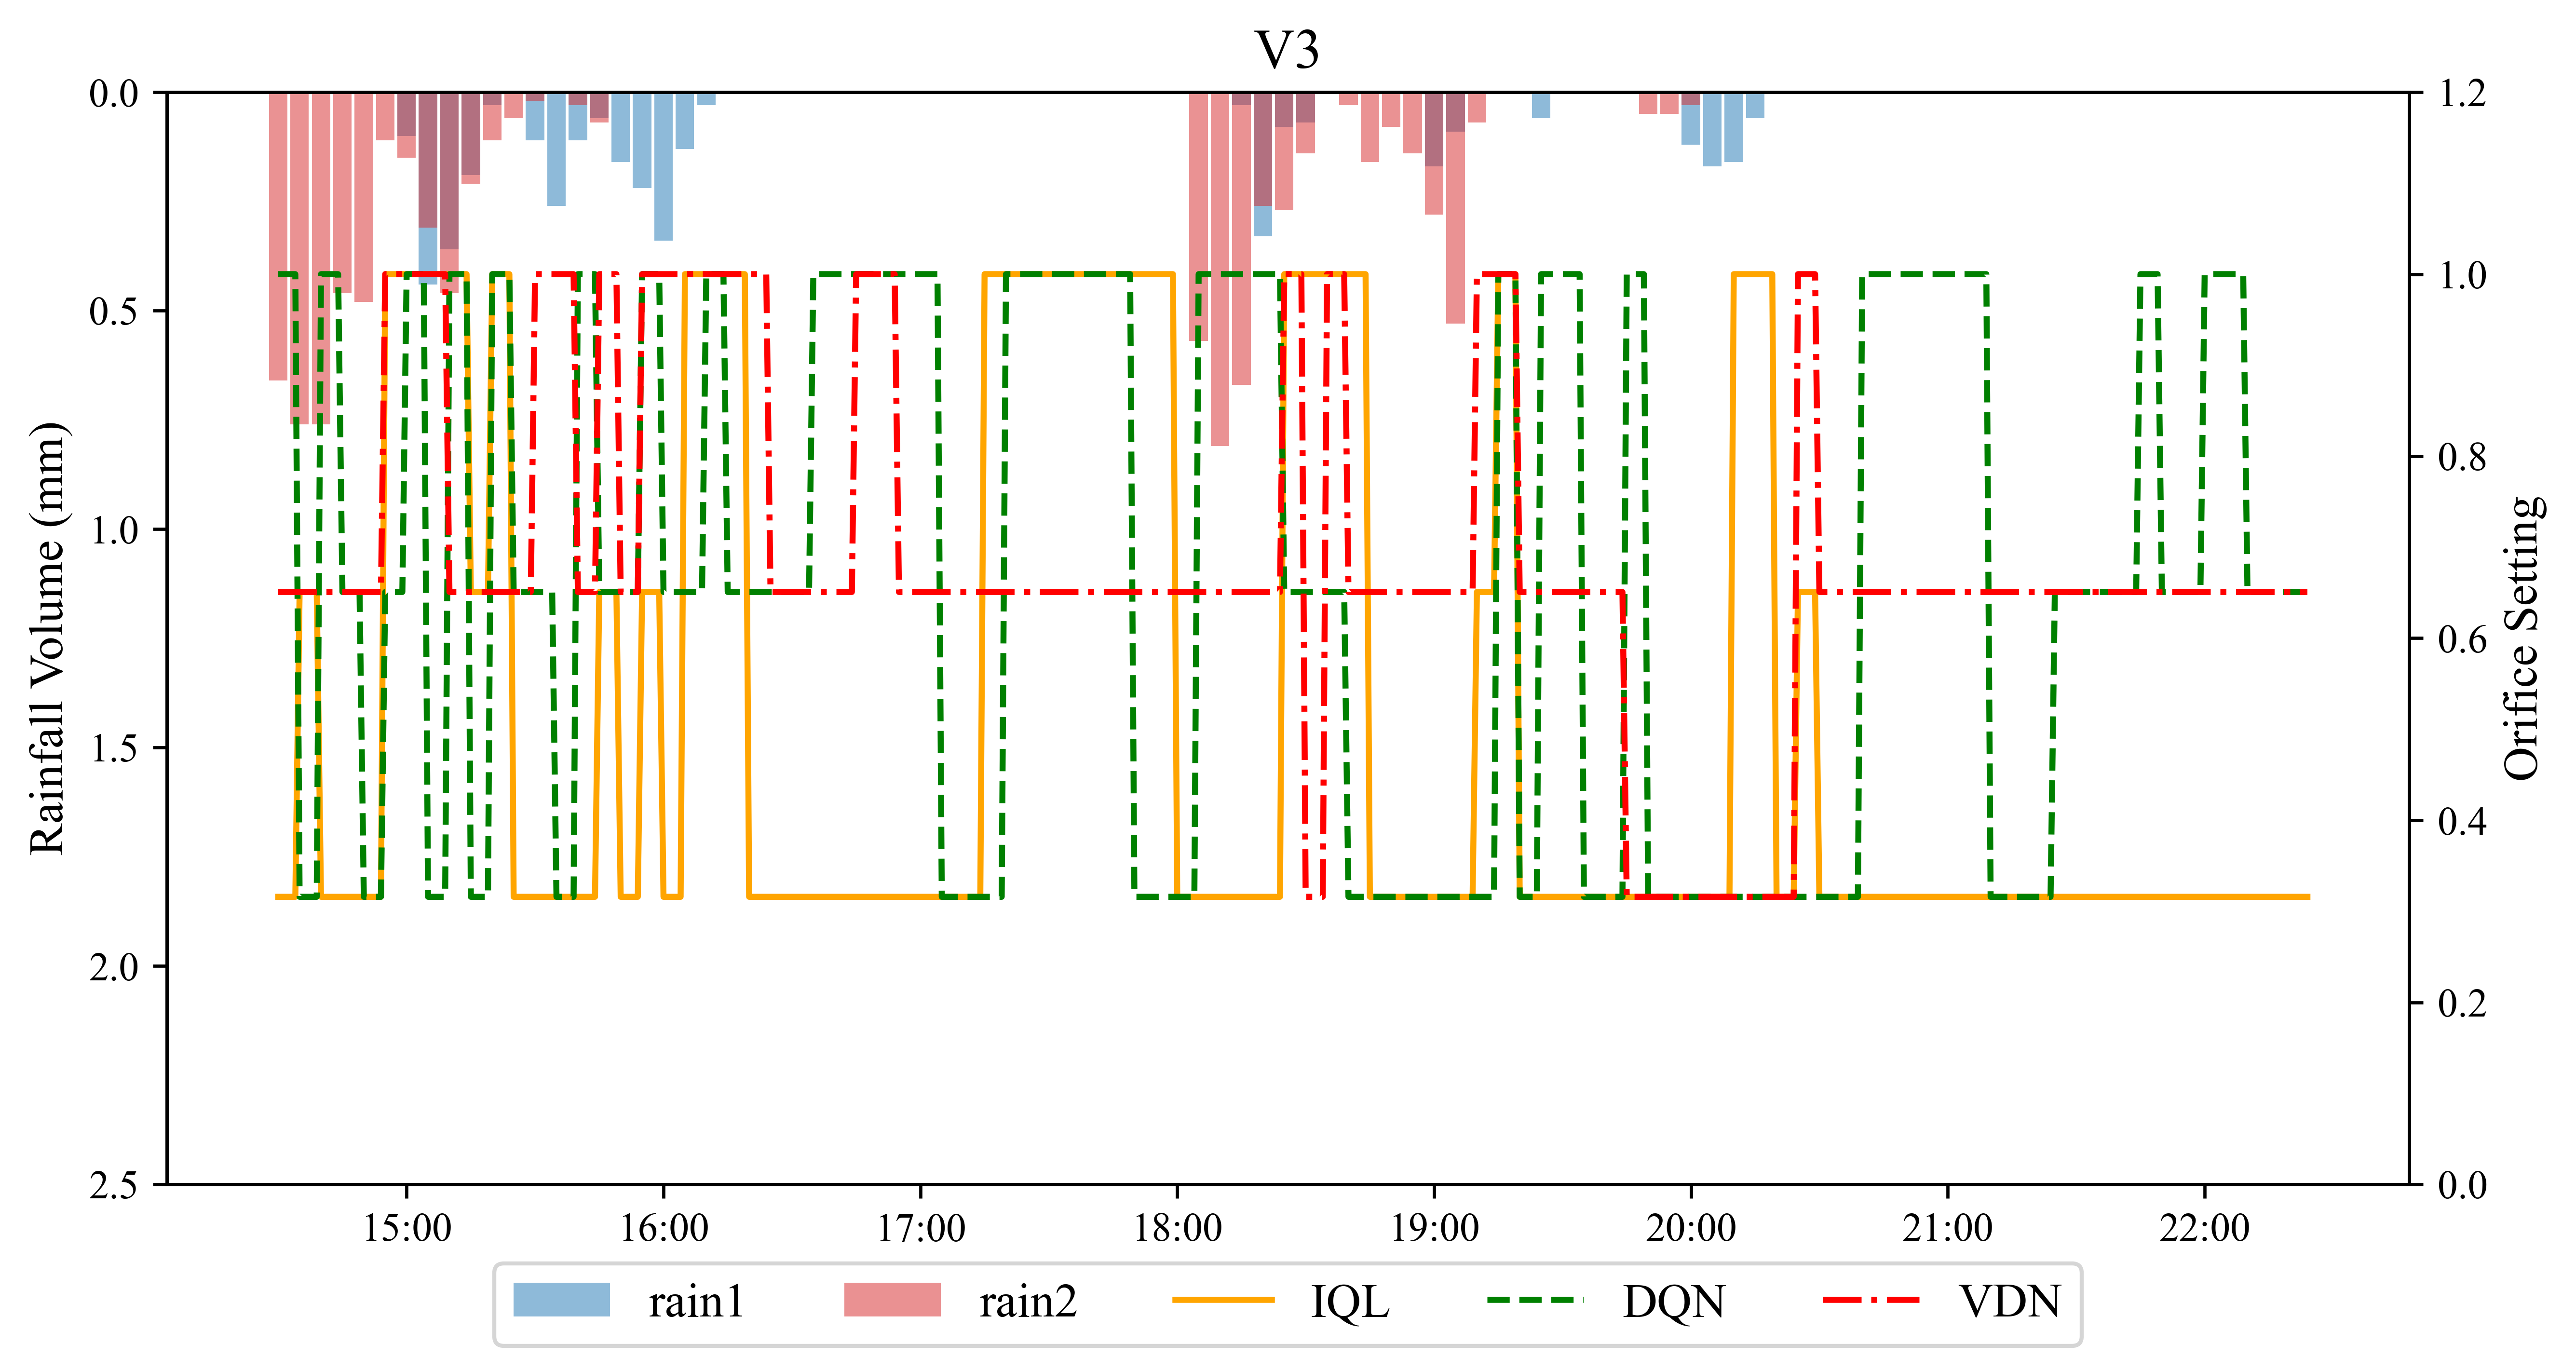

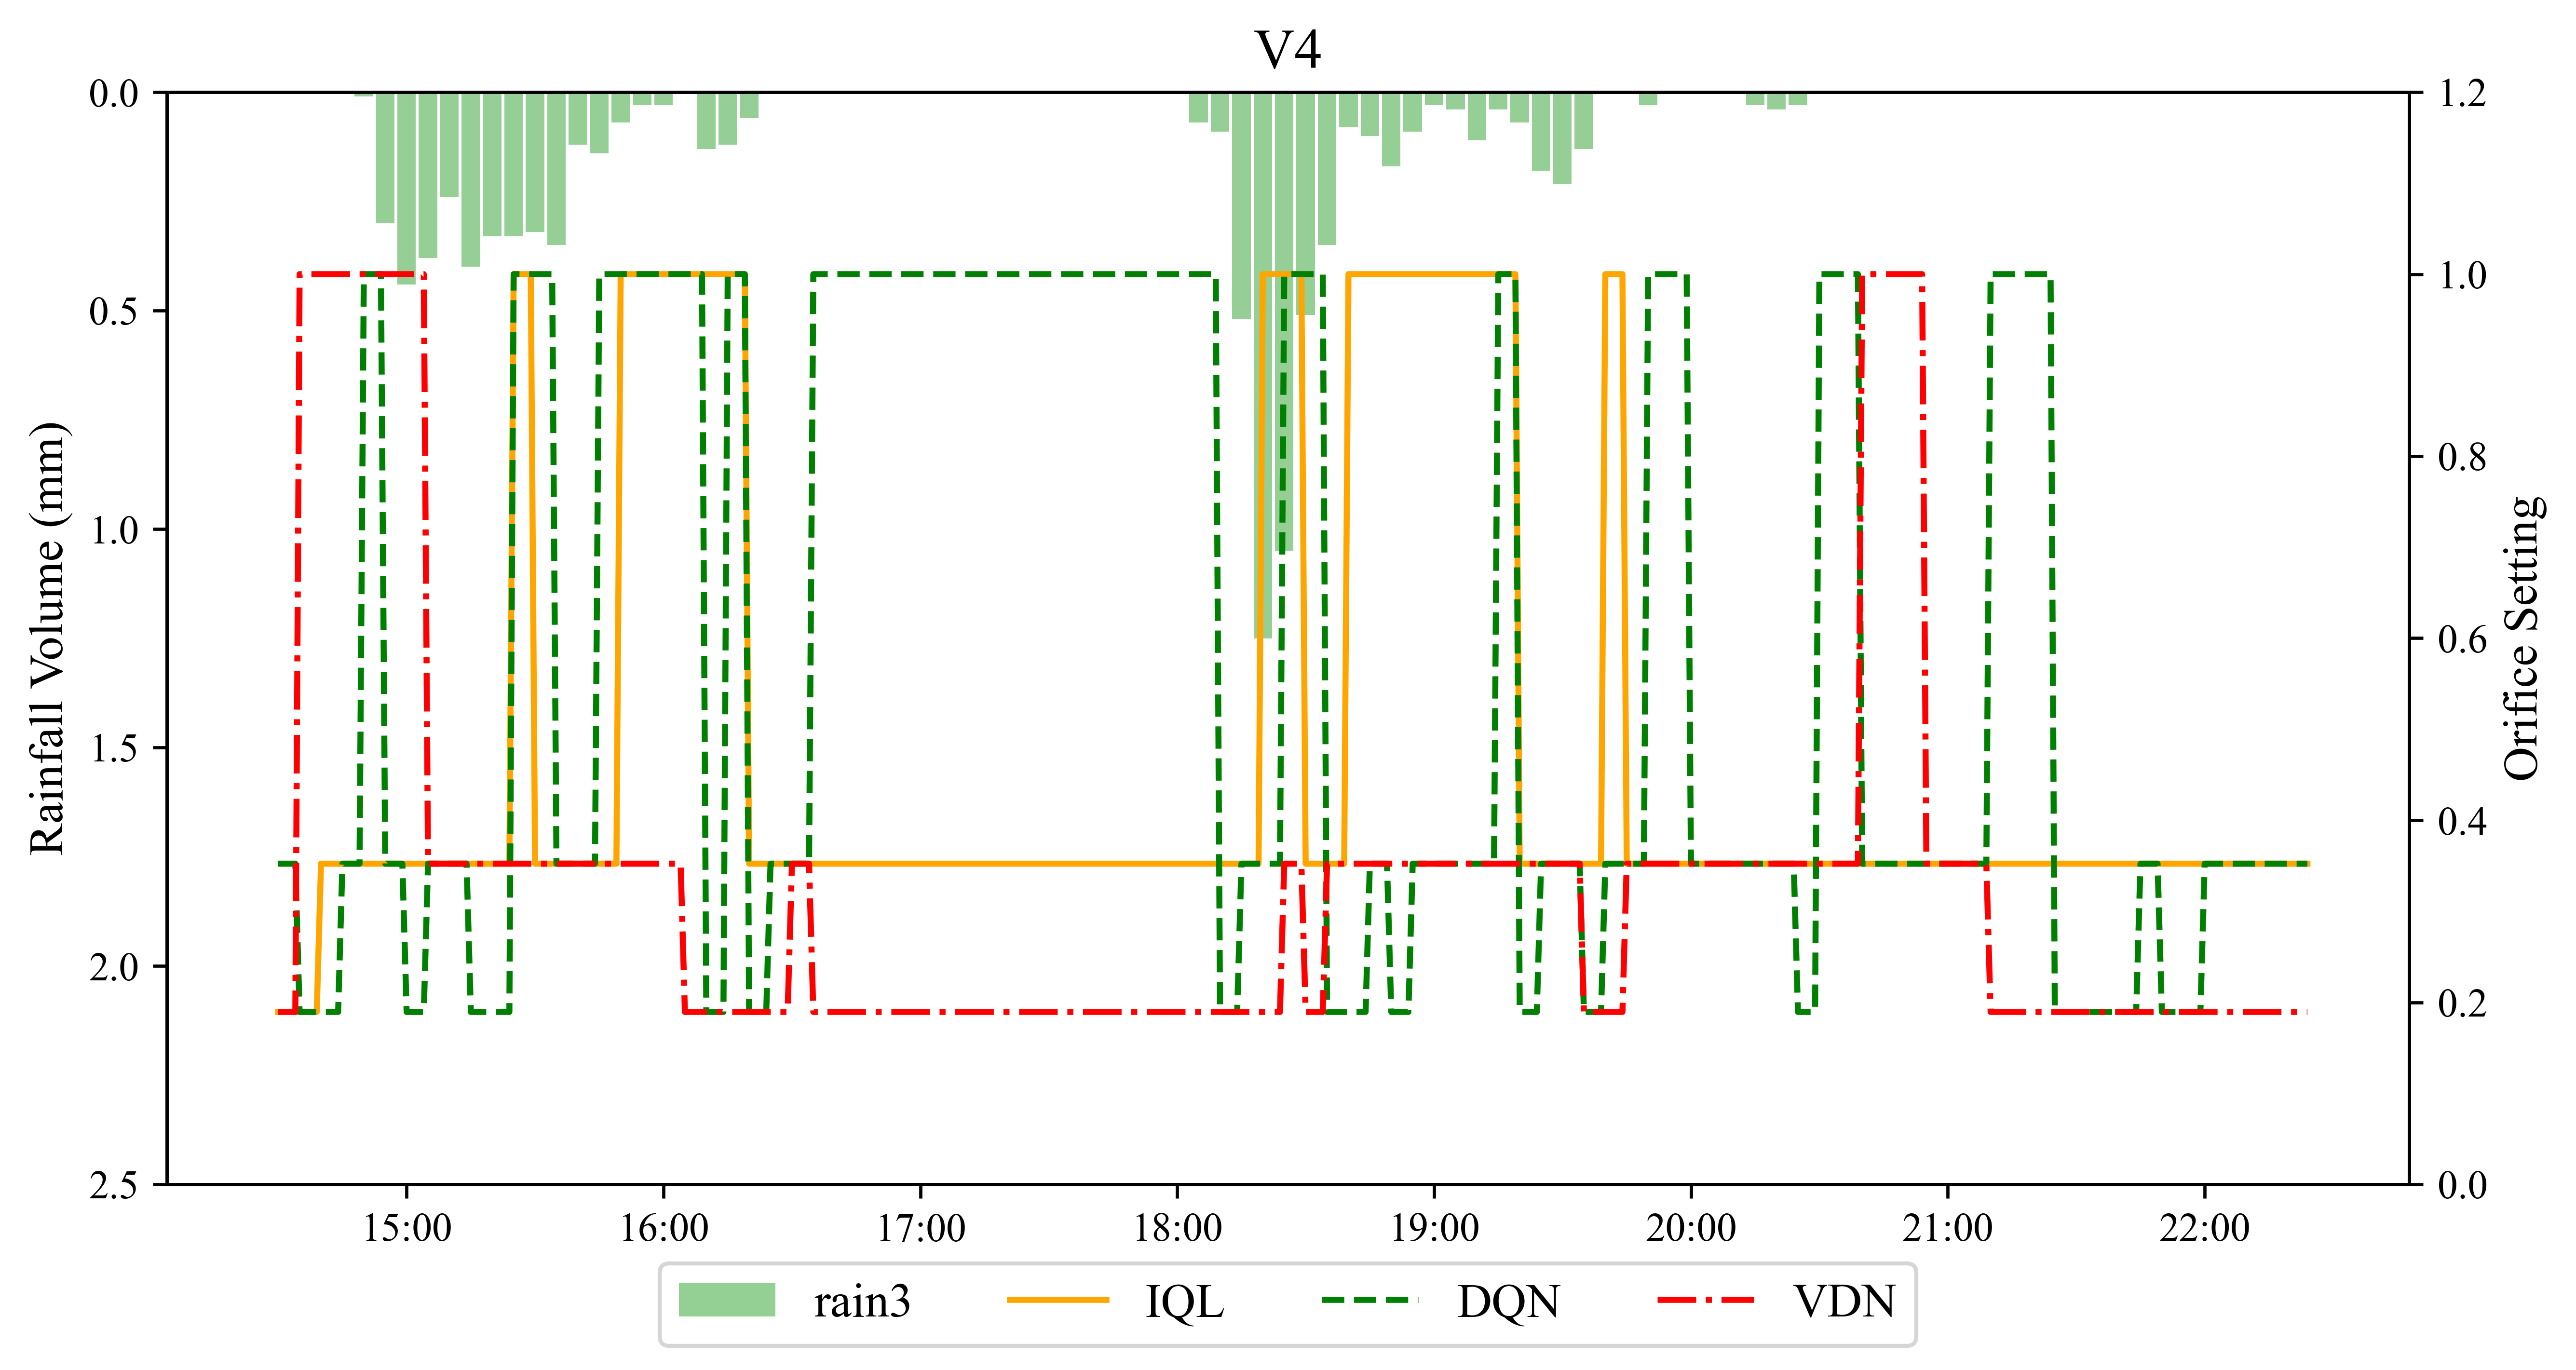

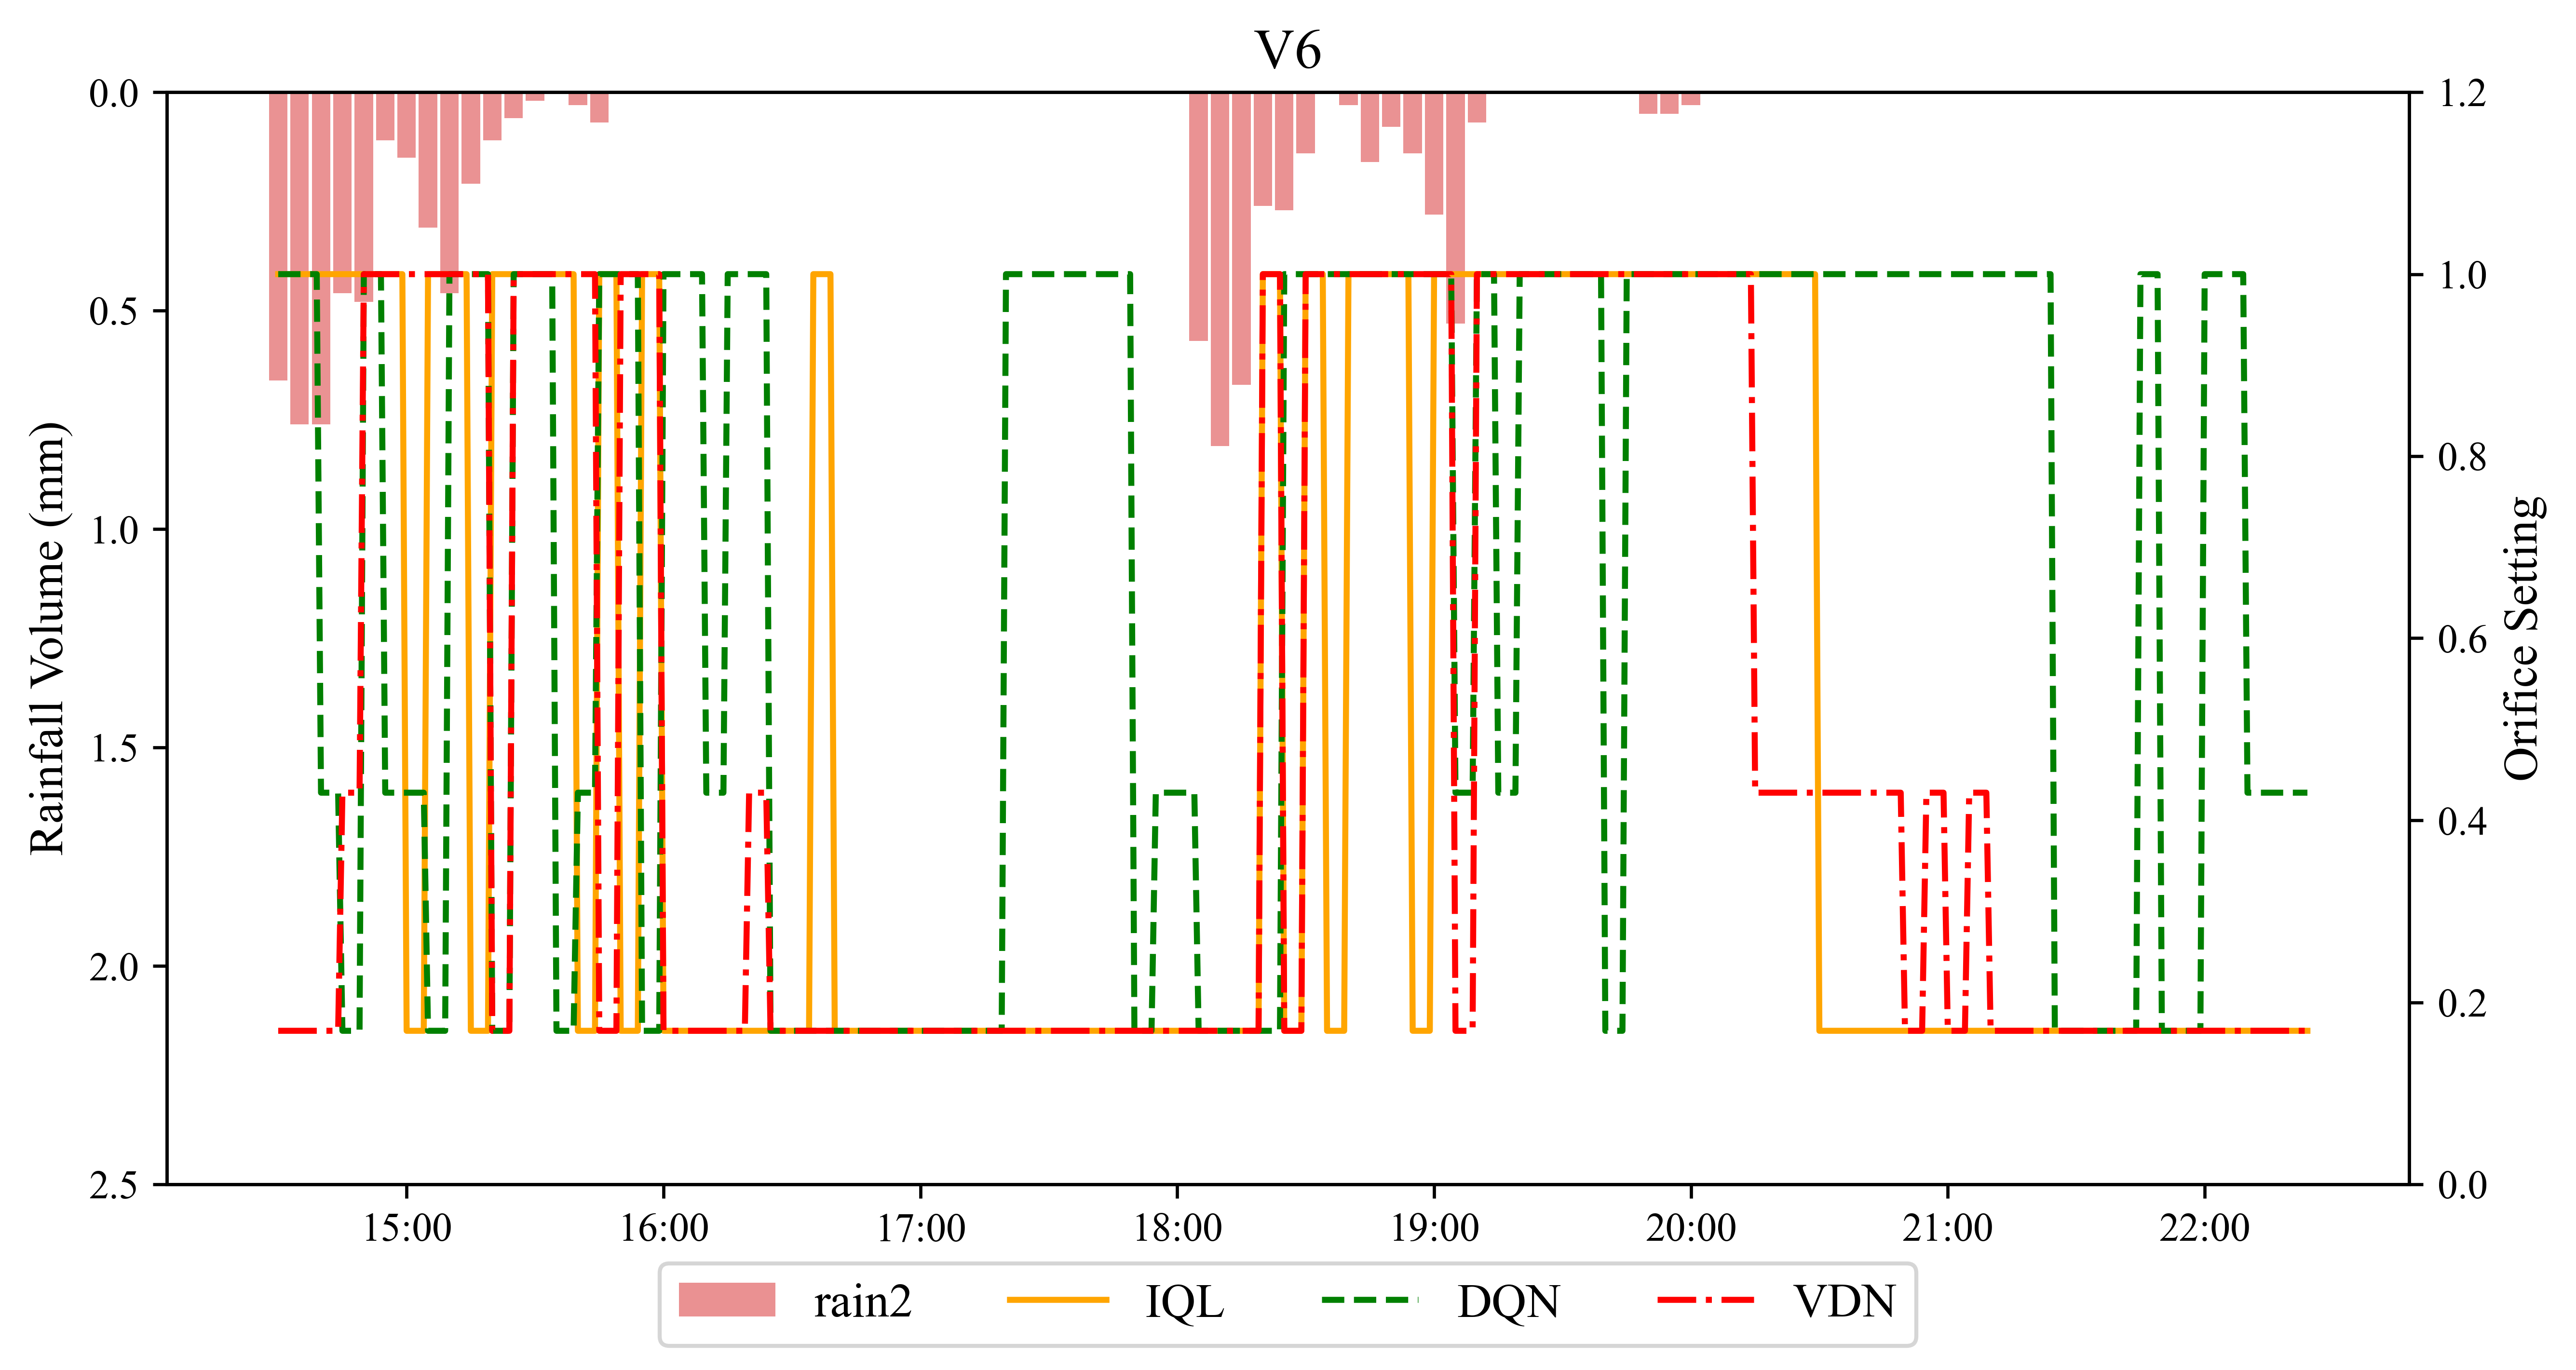

In [20]:


RG = {2:[('rain3','#2ca02c')],3:[('rain1','#1f77b4'),('rain2','#d62728')],
      4:[('rain3','#2ca02c')],6:[('rain2','#d62728')]}    
for i in [2,3,4,6]:
    objs = []
    settings = []
    for file in files:
        out = read_out_file(file.replace('inp','out'))
        settings.append(out.get_part('link','V%s'%i)['Capacity'])
        out.close()
    
    fig = plt.figure(figsize=(10,5),dpi = 600)
    ax = fig.add_subplot(1,1,1)
    ax.set_title('V%s'%i,fontsize=14)
    for col in RG[i]:
        ba = ax.bar(rains.index,rains[col[0]],
                    label=col[0],color=col[1],width=0.003,alpha=0.5,zorder=1)
        objs.append(ba)
    ax2 = ax.twinx()
    ax.invert_yaxis()
    ax.set_ylim((rains.max().max()*2,0))
    
    

    time = settings[0].index.tolist()
    time = [t+timedelta(minutes=i) for t in time for i in range(5)]
    capa = [[ca for ca in setting.values.tolist() for i in range(5)] 
            for setting in settings]
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    
    cap1 = ax2.plot(time,capa[0],'-',color= 'orange',label = 'IQL')
    cap2 = ax2.plot(time,capa[1],'--',color= 'green',label = 'DQN')  
    cap3 = ax2.plot(time,capa[2],'-.',color= 'red',label = 'VDN')  
    ax2.set_ylim([0,1.2])    
    
    ax2.yaxis.set_ticks_position('right')
    ax2.yaxis.set_label_position('right')
    ax.set_ylabel('Rainfall Volume (mm)',fontsize=12)
    ax2.set_ylabel('Orifice Setting',fontsize=12)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    objs.sort(key=lambda x:x.get_label())
    objs += cap1+cap2+cap3
    fig.legend(objs,[l.get_label() for l in objs],loc=8,ncol=6,fontsize=12)
    fig.savefig('./test/details/setting_V%s.png'%i) 


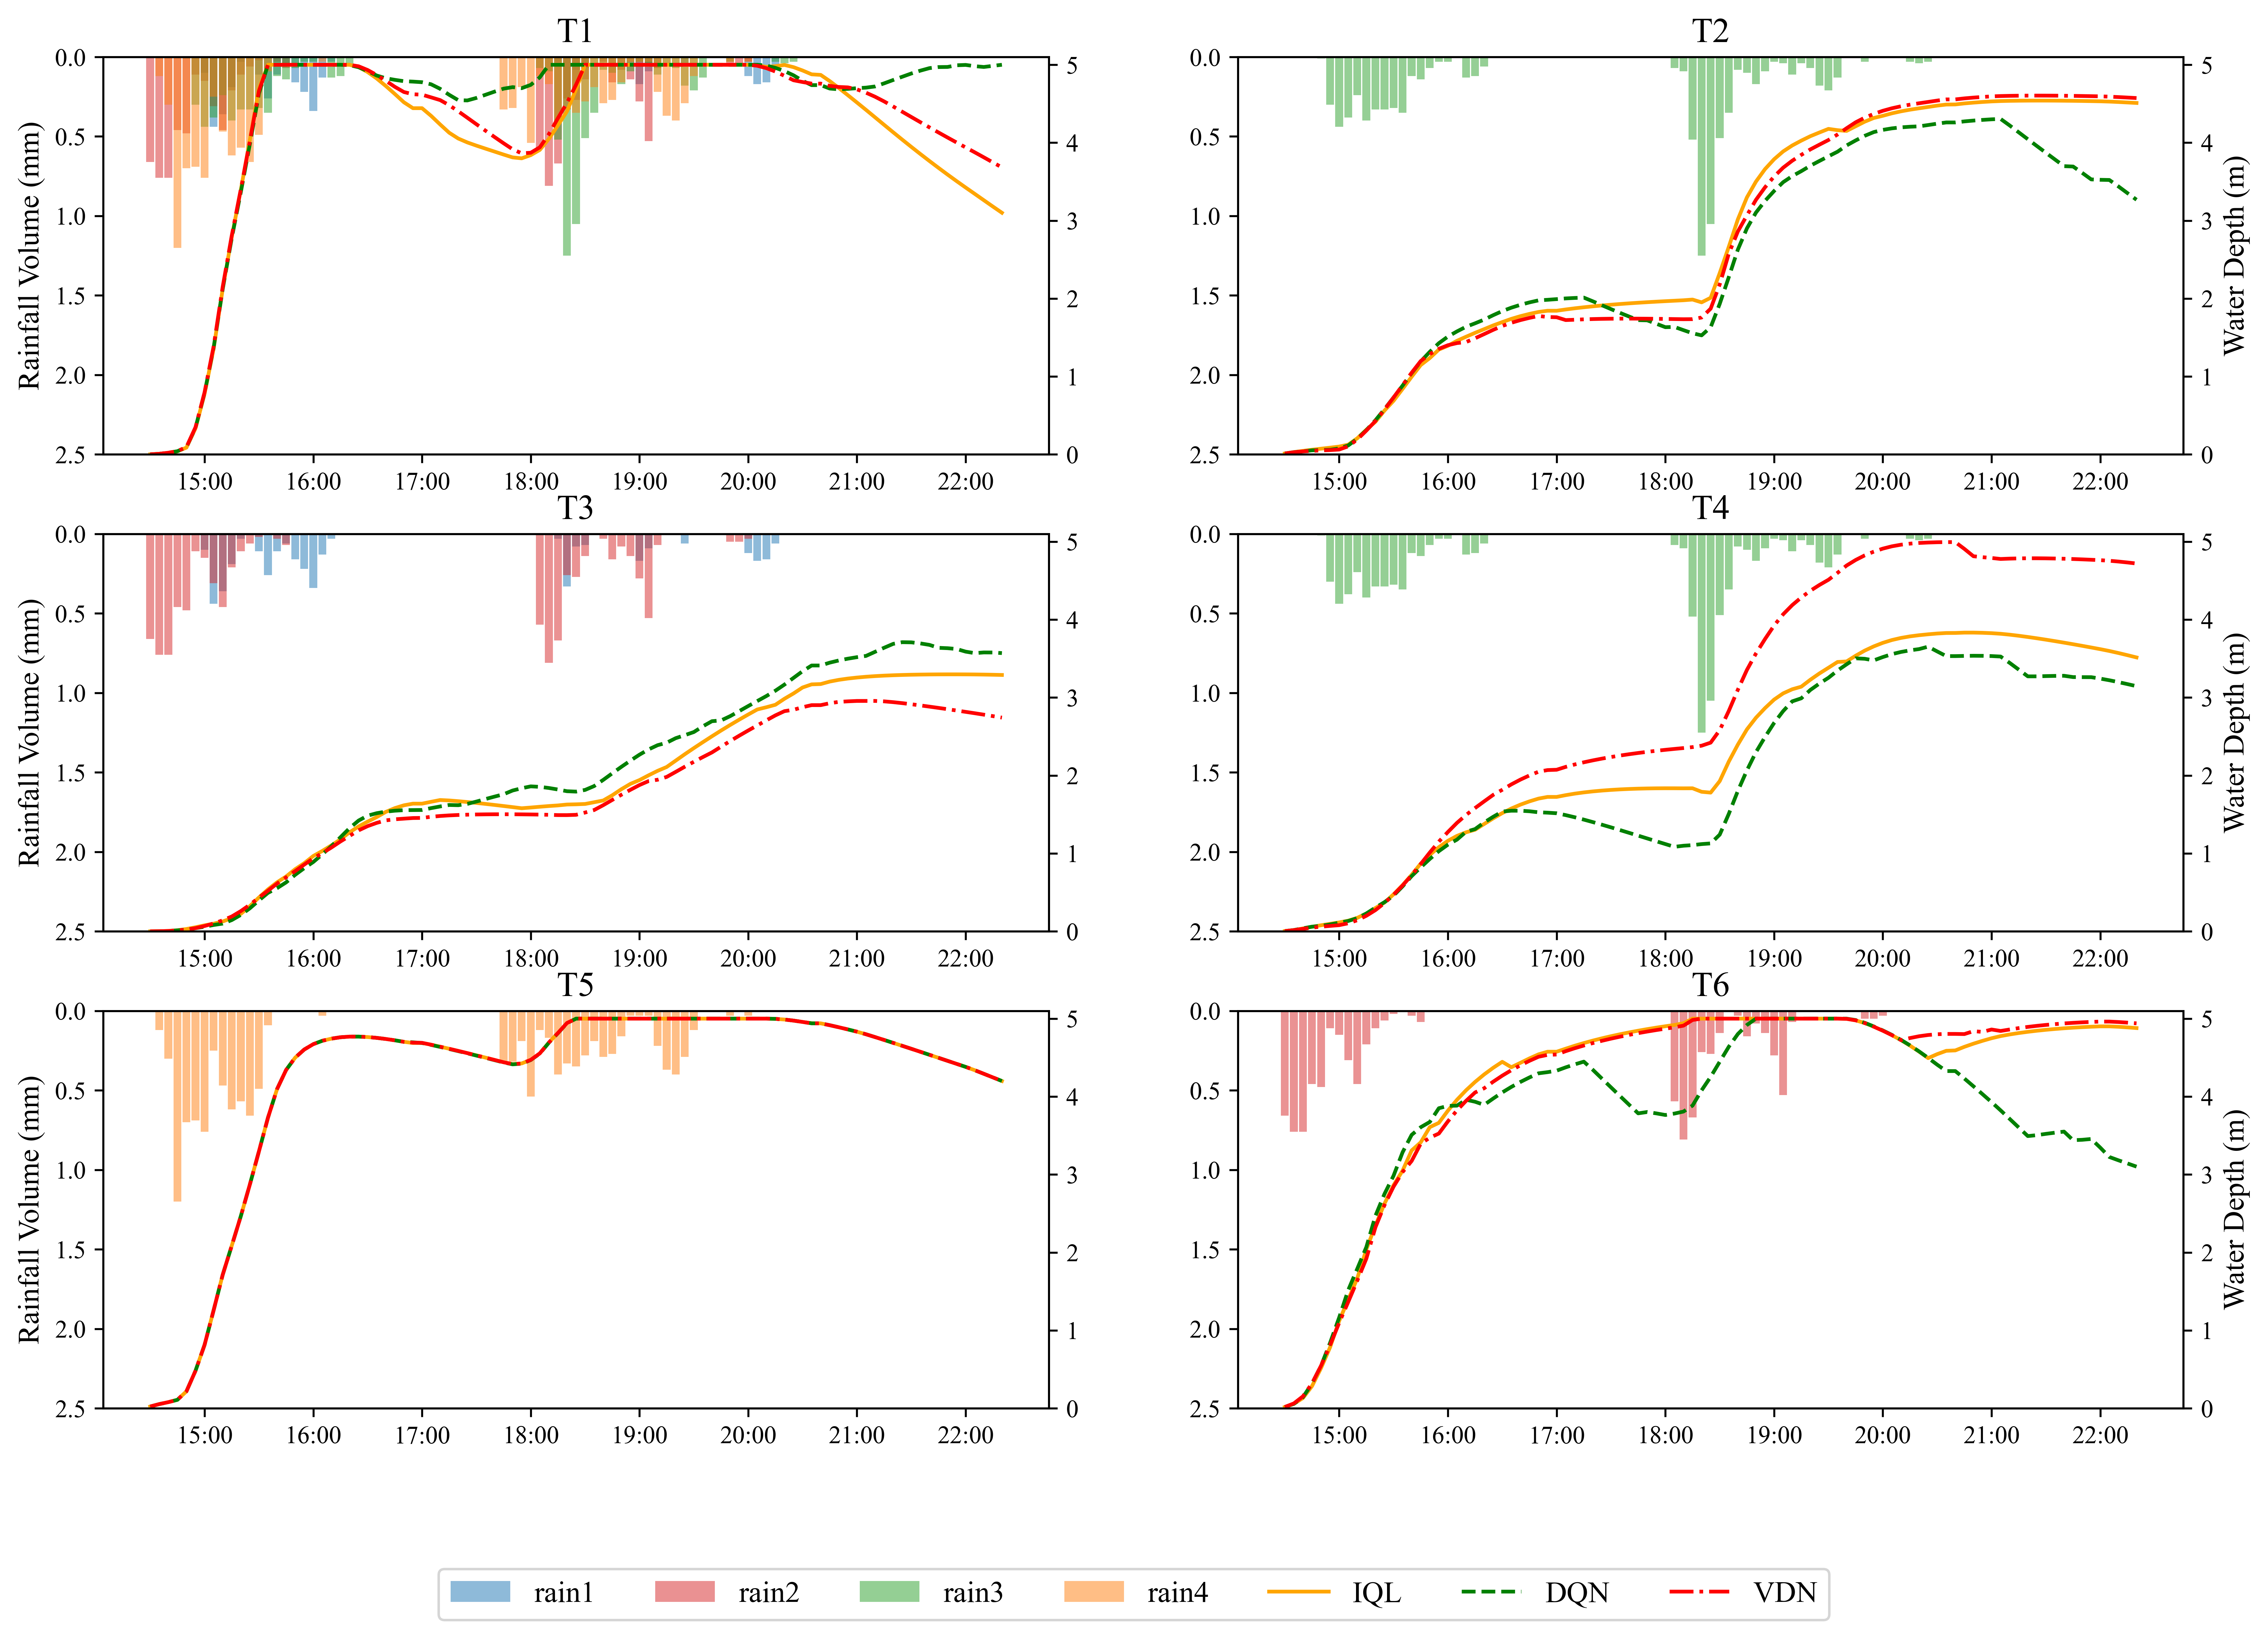

In [21]:
RG = {1:[('rain1','#1f77b4'),('rain2','#d62728'),('rain3','#2ca02c'),('rain4','#ff7f0e')],
      2:[('rain3','#2ca02c')],3:[('rain1','#1f77b4'),('rain2','#d62728')],
      4:[('rain3','#2ca02c')],5:[('rain4','#ff7f0e')],6:[('rain2','#d62728')]}      
fig = plt.figure(figsize=(15,10),dpi=600)
objs = []
for idx,i in enumerate([1,2,3,4,5,6]):
    depths = []
    for file in files:
        out = read_out_file(file.replace('inp','out'))
        depths.append(out.get_part('node','T%s'%i)['Depth_above_invert'])
        out.close()
    
    ax = fig.add_subplot(3,2,idx+1)
    ax.set_title('T%s'%i,fontsize=14)
    for col in RG[i]:
        ba = ax.bar(rains.index,rains[col[0]],
                    label=col[0],color=col[1],width=0.003,alpha=0.5,zorder=1)
        if i == 1:
            objs.append(ba)
    ax2 = ax.twinx()
    ax.invert_yaxis()
    ax.set_ylim((rains.max().max()*2,0))

    time = depths[0].index.tolist()
    dep = [depth.values.tolist()
           for depth in depths]
    
    depth = ax2.plot(time,dep[0],'-',color= 'orange', label = 'IQL')
    depth2 = ax2.plot(time,dep[1],'--',color= 'green', label = 'DQN')
    depth3 = ax2.plot(time,dep[2],'-.',color= 'red', label = 'VDN')
    ax2.set_ylim([0,5.1])    
    
    ax2.yaxis.set_ticks_position('right')
    ax2.yaxis.set_label_position('right')
    if i%2 == 1:
        ax.set_ylabel('Rainfall Volume (mm)',fontsize=12)
    else:
        ax2.set_ylabel('Water Depth (m)',fontsize=12)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    if i == 1:
        objs.sort(key=lambda x:x.get_label())
        objs += depth+depth2+depth3
fig.legend(objs,[l.get_label() for l in objs],loc=8,ncol=7,fontsize=12)
fig.savefig('./test/details/depths.png') 